# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np

# 2. Load Data

In [ ]:
# 1. Load the Dataset
df = pd.read_csv("dataset.csv")

# 2. View the Dataset Descriptive Stats
df.describe()

In [ ]:
# 3. View First 5 Rows
df.head()

# 3. Pre-process Data

## 3.1. Merge Product Details

In [ ]:
# Define product consolidation mapping
product_groups = {
    'Brazilian - Organic': ['Brazilian Lg', 'Brazilian Rg', 'Brazilian Sm'],
    'Cappuccino': ['Cappuccino Lg'],
    'Columbian Medium Roast': ['Columbian Medium Roast Lg', 'Columbian Medium Roast Rg', 'Columbian Medium Roast Sm'],
    'Dark chocolate': ['Dark chocolate Lg', 'Dark chocolate Rg'],
    'Earl Grey': ['Earl Grey Lg', 'Earl Grey Rg'],
    'English Breakfast': ['English Breakfast Lg', 'English Breakfast Rg'],
    'Ethiopia': ['Ethiopia Lg', 'Ethiopia Rg', 'Ethiopia Sm'],
    'Jamacian Coffee River': ['Jamacian Coffee River', 'Jamaican Coffee River Lg', 'Jamaican Coffee River Rg', 'Jamaican Coffee River Sm'],
    'Latte': ['Latte Rg'],
    'Lemon Grass': ['Lemon Grass Lg', 'Lemon Grass Rg'],
    'Morning Sunrise Chai': ['Morning Sunrise Chai Lg', 'Morning Sunrise Chai Rg'],
    'Our Old Time Diner Blend': ['Our Old Time Diner Blend Lg', 'Our Old Time Diner Blend Rg', 'Our Old Time Diner Blend Sm'],
    'Peppermint': ['Peppermint Lg', 'Peppermint Rg'],
    'Serenity Green Tea': ['Serenity Green Tea Lg', 'Serenity Green Tea Rg'],
    'Spicy Eye Opener Chai': ['Spicy Eye Opener Chai Lg', 'Spicy Eye Opener Chai Rg'],
    'Sustainably Grown Organic': ['Sustainably Grown Organic Lg', 'Sustainably Grown Organic Rg'],
    'Traditional Blend Chai': ['Traditional Blend Chai Lg', 'Traditional Blend Chai Rg']
}

# Loop through each Group and Apply the Update
for main_product, variants in product_groups.items():
    try:
        # 1. Get Canonical product_id
        canonical_id = df.loc[df['product_detail'] == main_product, 'product_id'].iloc[0]

        # 2. Update product_detail for Variants
        df.loc[df['product_detail'].isin(variants), 'product_detail'] = main_product

        # 3. Set product_id for All Rows with the Merged Name
        df.loc[df['product_detail'] == main_product, 'product_id'] = canonical_id
    except IndexError:
        print(f"Warning: Canonical product_id for '{main_product}' not found in df. Skipped.")


## 3.2. Data Aggregation

Each row represents one day at a certain store.

In [ ]:
# [1] Combine Datetime
df['datetime'] = pd.to_datetime(df['transaction_date'] + ' ' + df['transaction_time'])

# [2] Extract Date
df['date'] = df['datetime'].dt.date

# [3] Aggregate Daily Product Totals (across stores)
daily_sales = df.groupby(['date', 'product_id', ])['transaction_qty'].sum().reset_index()

# [4] Pivot to Wide Format
df_wide = daily_sales.pivot(index='date', columns='product_id', values='transaction_qty').fillna(0)
df_wide.columns = [f'prod_{col}' for col in df_wide.columns]
df_wide.reset_index(inplace=True)

# [5] Add Calendar Features
df_wide['date'] = pd.to_datetime(df_wide['date'])
df_wide['month'] = df_wide['date'].dt.month
df_wide['dayofweek'] = df_wide['date'].dt.dayofweek
df_wide['is_weekend'] = df_wide['dayofweek'].isin([5, 6]).astype(int)

In [ ]:
df_wide.head()

## 3.3. Add Lagging Features

In [ ]:
# [1] Sort by Date
df_wide = df_wide.sort_values(by='date')

# [2] Define Lag Windows
lag_days = [1, 2, 3]

# [3] Identify Product Columns (they all start with 'prod_')
product_cols = [col for col in df_wide.columns if col.startswith('prod_')]

# [4] Add Lag Features for Each Product
lagged_cols = {}
for col in product_cols:
    for lag in lag_days:
        lagged_name = f'{col}_lag_{lag}'
        lagged_cols[lagged_name] = df_wide[col].shift(lag)

# [5] Concatenate Lagged Features
df_lags = pd.concat(lagged_cols, axis=1)

# [6] Combine with Original DF
df_wide = pd.concat([df_wide, df_lags], axis=1)

# [5] Drop NaN Rows due to Shifting
df_wide.dropna(inplace=True)
df_wide.reset_index(drop=True, inplace=True)

In [ ]:
df_wide.head()

In [ ]:
df_wide.to_csv('final_dataset.csv', index=False)

# 4. Load and Preprocess the Final Dataset

## 4.1. Load the Dataset

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('final_dataset.csv')

## 4.2. Create X and Y Datasets

In [5]:
# [1] Identify Target Columns
product_cols = [col for col in df.columns if col.startswith('prod_') and '_lag_' not in col]

# [2] Identify Lagged Features
lag_cols = [col for col in df.columns if '_lag_' in col]

# [3] Identify Calendar Features
calendar_cols = ['month', 'dayofweek', 'is_weekend']

# [4] Combine Feature Columns
x_cols = calendar_cols + lag_cols

# [5] Split
x = df[x_cols].copy()
y = df[product_cols].copy()

In [6]:
print(x.shape)
print(y.shape)

(178, 132)
(178, 43)


## 4.3. Split into Training and Testing Datasets

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 4.4. Normalize X

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## 4.5. Convert to 3d Tensor for CNN-LSTM

In [9]:
# [1] Function to Create Sequences
def create_sequences(x, y, seq_len = 3):
    x_seq, y_seq = [], []

    for i in range(seq_len, len(x)):
        x_seq.append(x[i-seq_len : i])
        y_seq.append(y.iloc[i].values)
    
    return np.array(x_seq), np.array(y_seq)

# [2] Function to Create Train and Test Sequences
seq_len = 3
x_train_seq, y_train_seq = create_sequences(x_train_scaled, y_train, seq_len)
x_test_seq, y_test_seq = create_sequences(x_test_scaled, y_test, seq_len)

In [10]:
print("x_train shape:", x_train_seq.shape)  # (n_train_samples, 3, n_features)
print("y_train shape:", y_train_seq.shape)  # (n_train_samples, n_products)

x_train shape: (139, 3, 132)
y_train shape: (139, 43)


In [11]:
print("x_test shape:", x_test_seq.shape)  # (n_train_samples, 3, n_features)
print("y_test shape:", y_test_seq.shape)  # (n_train_samples, n_products)

x_test shape: (33, 3, 132)
y_test shape: (33, 43)


# 5. Prediction Model

## 5.1. PyTorch Dataset and DataLoader

In [12]:
# Time Series Dataset Function
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x) # Total No. of Sequences

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [13]:
from torch.utils.data import DataLoader

# Create Training and Testing Datasets
train_dataset = TimeSeriesDataset(x_train_seq, y_train_seq)
test_dataset = TimeSeriesDataset(x_test_seq, y_test_seq)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Quick Check
sample_x, sample_y = train_dataset[0]
print("x Shape: ", sample_x.shape)
print("y Shape: ", sample_y.shape)

x Shape:  torch.Size([3, 132])
y Shape:  torch.Size([43])


## 5.2. Create CNN+LSTM Class

In [15]:
import torch
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self, input_features, hidden_size, output_size):
        super(CNNLSTM, self).__init__()

        # CNN: in_channels = features_per_day
        self.cnn = nn.Sequential(
                                    nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=3, padding=1),
                                    nn.Tanh(),
                                    nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                    nn.Tanh()
        )

        # LSTM: input_size=32 (from CNN output channels)
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, batch_first=True)

        # Fully Connected: from LSTM Hidden to Output Targets
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        x shape: (batch_size, sequence_length, input_features)
        """

        # [1] CNN: Expects (batch_size, in_channels, sequence_length)
        x = x.permute(0, 2, 1)                  # shape: (batch_size, input_features, sequence_length)
        x = self.cnn(x)                         # shape: (batch_size, 32, sequence_length)
        x = x.permute(0, 2, 1)                  # shape: (batch_size, sequence_length, 32)

        # [2] LSTM: Expects (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)              # shape: (batch_size, sequence_length, hidden_size)

        # [3] Take Output of the Last Timestep
        last_output = lstm_out[:, -1, :]        # shape: (batch_size, hidden_size)

        return self.fc(last_output)             # shape: (batch_size, output_size)

## 5.3. Model Training

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

input_features = x_train_seq.shape[2]
output_size = y_train_seq.shape[1]
hidden_size = 64

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNLSTM(input_features=input_features, hidden_size=hidden_size, output_size=output_size)

model.to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5.4. Training Loop

In [18]:
def train_model(model, train_loader, test_loader, epochs=20):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on Test Data
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)

                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    return train_losses, test_losses

In [19]:
# Train the Model
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=300)

Epoch  1 | Train Loss: 1511.7152 | Test Loss: 1152.9878
Epoch  2 | Train Loss: 1548.7875 | Test Loss: 1144.9984
Epoch  3 | Train Loss: 1479.0968 | Test Loss: 1132.4758
Epoch  4 | Train Loss: 1484.2973 | Test Loss: 1115.1133
Epoch  5 | Train Loss: 1432.2914 | Test Loss: 1093.4464
Epoch  6 | Train Loss: 1385.9169 | Test Loss: 1069.5338
Epoch  7 | Train Loss: 1434.6987 | Test Loss: 1045.5361
Epoch  8 | Train Loss: 1363.7647 | Test Loss: 1022.7276
Epoch  9 | Train Loss: 1414.5491 | Test Loss: 1001.5897
Epoch 10 | Train Loss: 1355.3877 | Test Loss: 981.8166
Epoch 11 | Train Loss: 1327.6840 | Test Loss: 963.2570
Epoch 12 | Train Loss: 1292.9473 | Test Loss: 945.7559
Epoch 13 | Train Loss: 1301.5288 | Test Loss: 929.2036
Epoch 14 | Train Loss: 1231.5869 | Test Loss: 913.3665
Epoch 15 | Train Loss: 1226.0017 | Test Loss: 898.2679
Epoch 16 | Train Loss: 1184.3731 | Test Loss: 883.7144
Epoch 17 | Train Loss: 1144.7082 | Test Loss: 869.7554
Epoch 18 | Train Loss: 1192.2382 | Test Loss: 856.2874
E

## 5.5. Plot Losses

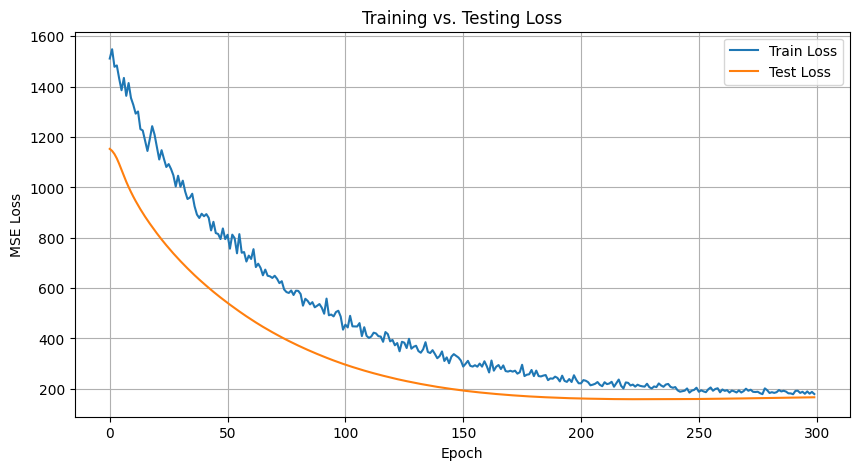

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Training vs. Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


## 5.6. Loss per Product

In [21]:
model.eval()                                        # set to evaluation mode
y_preds = []

with torch.no_grad():                               # disables gradient computation
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)                # send to GPU if available
        y_pred = model(X_batch)                     # shape: (batch_size, n_products)
        y_preds.append(y_pred.cpu().numpy())        # move to CPU and convert to numpy

y_pred_all = np.concatenate(y_preds, axis=0)        # shape: (total_test_samples, n_products)

In [22]:
print("Predictions shape:", y_pred_all.shape)
print("Targets shape:", y_test_seq.shape)

Predictions shape: (33, 43)
Targets shape: (33, 43)


In [23]:
from sklearn.metrics import mean_absolute_error
import numpy as np

n_products = y_test_seq.shape[1]

mae_per_product = []
rmse_per_product = []

for i in range(n_products):
    y_true = y_test_seq[:, i]
    y_pred = y_pred_all[:, i]

    mae = mean_absolute_error(y_true, y_pred)

    mae_per_product.append(mae)

    print(f"📦 Product {i+1}: MAE = {mae:.2f}")


📦 Product 1: MAE = 22.98
📦 Product 2: MAE = 22.41
📦 Product 3: MAE = 0.96
📦 Product 4: MAE = 0.66
📦 Product 5: MAE = 20.37
📦 Product 6: MAE = 24.02
📦 Product 7: MAE = 18.32
📦 Product 8: MAE = 1.95
📦 Product 9: MAE = 1.18
📦 Product 10: MAE = 0.78
📦 Product 11: MAE = 15.57
📦 Product 12: MAE = 15.59
📦 Product 13: MAE = 13.76
📦 Product 14: MAE = 15.11
📦 Product 15: MAE = 16.54
📦 Product 16: MAE = 16.78
📦 Product 17: MAE = 17.04
📦 Product 18: MAE = 17.77
📦 Product 19: MAE = 15.39
📦 Product 20: MAE = 17.52
📦 Product 21: MAE = 0.86
📦 Product 22: MAE = 7.66
📦 Product 23: MAE = 13.56
📦 Product 24: MAE = 12.73
📦 Product 25: MAE = 11.35
📦 Product 26: MAE = 8.80
📦 Product 27: MAE = 11.17
📦 Product 28: MAE = 3.79
📦 Product 29: MAE = 2.85
📦 Product 30: MAE = 6.10
📦 Product 31: MAE = 6.94
📦 Product 32: MAE = 3.33
📦 Product 33: MAE = 3.58
📦 Product 34: MAE = 3.42
📦 Product 35: MAE = 3.49
📦 Product 36: MAE = 3.70
📦 Product 37: MAE = 3.59
📦 Product 38: MAE = 3.61
📦 Product 39: MAE = 1.12
📦 Product 40: M